# TP Titanic - Modèles de regressions et modèles ensemblistes

## Introduction

Les données du dataset titanic présentent un ensemble de passagers avec diverses caractéristiques, dont une variable indiquant s'ils ont survécu ou non. L'objectif est d'élaborer des modèles statistiques pour essayer de prédire quel passager a des chances de survivre en connaissant ses caractéristiques.

## Importation et étude des données

### Type des variables

La première étape est d'importer les données qui sont disponibles au format CSV. On stocke les données dans une DataFrame pour pouvoir étudier la structure de notre dataset.

In [1]:
import pandas as pd
import numpy as np
import titanic.preprocessing as preprocess
import titanic.models as models

data = preprocess.loadfile('titanic_train.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Le dataset comporte au total 12 variables (colonnes) pour 891 entrées (lignes). Les variables `PassengerId`, `Age`, `SibSp`, `Parch` et `Fare` sont quantitatives, toutes les autres son qualitatives.

### Données manquantes

On peut remarquer des valeurs manquantes (`NaN`) dans les données. On va remplacer ces valeurs par la médiane pour les variables quantitatives et par le mode pour les variables qualitatives. Voici le nombre de données manquantes par variable :

In [2]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
data = preprocess.input_missing_values(data)
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Après traitement on a bien supprimé toutes les valeurs `NaN`. Il est important de noter qu'il y avait 687 valeurs manquantes (sur 891) pour la variable `Cabin`, ce qui représente **77%** des valeurs de cette variable. Il semble donc peu pertinent de sélectionner cette variable dans un futur modèle.

### Variable cible

Dans cette étude, variable cible (target) sera la colonne `Survived`, qui représente si le passager en question du Titanic est décédé (`0`) ou a survécu (`1`).

In [4]:
dead = data[data['Survived']==0]
survived = data[data['Survived']==1]

# Target
y = data['Survived']
print(dead.shape)
print(survived.shape)

(549, 12)
(342, 12)


Il y a au total 342 personnes qui ont survécu et 549 qui sont mortes. Cela représente 38% de survivants.

## Première modélisation: Logistic Regression avec les variables `SibSp`, `Parch`, `Fare`

### Séparation des données en set *train* et *test*

Pour évaluer de manière efficace, on va séparer les données d'entrée en **train set** et **test set**. Le train set est utilisé pour entraîner et générer le modèle, et le test set est utilisé pour vérifier à quel point le modèle est fiable et précis. On sélectionne par la même occasion les variables (features) que l'on souhaite intégrer au modèle.

In [5]:
features = ['SibSp', 'Parch', 'Fare']
X_train, X_test, y_train, y_test = preprocess.parse_model(X=data.copy(), use_columns=features)

##### Note: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

### Régression logistique avec `SibSp`, `Parch`, `Fare`

In [6]:
from sklearn.linear_model import LogisticRegression

features = ['SibSp', 'Parch', 'Fare']
model, X_test, y_test = models.logistic(data, features)
print(model.score(X_test, y_test))

0.7039106145251397


### Performances et score de la première régression

Pour mesurer la performance du modèle que l'on vient d'entrainer, on utilise plusieurs métriques. Le score (qui correspons à accuracy) mais aussi la précision et le recall. De plus, comme ces métriques se basent sur un modèle dont les set train et test ont été choisi aléatoirement, on va effectuer une cross-validation avec un Kfold pour élaborer un intervalle de confiance (à 95%) de l'accuracy. Cela nous donnera une bonne estimation de la performance du modèle de Régression Logistiques avec les variables `SibSp`, `Parch` et `Fare`.

In [7]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

print(classification_report(model.predict(X_test), y_test))
scores = models.cross_val_model(data, LogisticRegression(), features)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

              precision    recall  f1-score   support

           0       0.95      0.68      0.80       152
           1       0.31      0.81      0.45        27

    accuracy                           0.70       179
   macro avg       0.63      0.75      0.63       179
weighted avg       0.86      0.70      0.75       179

Accuracy: 0.67 (+/- 0.09)


## Deuxième modélisation : Logistic Regression en ajoutant `Pclass`

Une part importante de la génération d'un modèle est la séléction des variables (features) de ce modèle. Pourquoi prendre une variable plutôt qu'une autre, et comment qualifier l'importance des variables.
Il existe plusieurs méthodes pour qualifier l'importance des variables dans une modélisation :
- les tests statistiques permettent de qualifier unitairement chaque variable
- le test du khi2 permet par exemple de verifier la dépendance entre chaque variable et la variable cible.
- Cela nécessite d'interpréter des p-values

Une alternative simple pour qualifier l'importance des variables dans le cas d'une modélisation est de visualiser la distribution d'une variable par rapport à la target. Par exemple, ici on va représenter la distribution de la variable `Pclass` :

Populating the interactive namespace from numpy and matplotlib


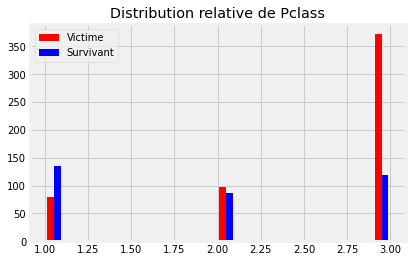

In [8]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline
%pylab inline

def plot_hist(feature, bins=20):
    x1 = np.array(dead[feature].dropna())
    x2 = np.array(survived[feature].dropna())
    plt.hist([x1, x2], label=["Victime", "Survivant"], bins=bins, color=['r', 'b'])
    plt.legend(loc="upper left")
    plt.title('Distribution relative de %s' %feature)
    plt.show()

plot_hist('Pclass')

On peut remarquer les éléments suivants :
- Une majorité de victimes provient de la classe 3
- A contrario les survivants proviennent plutot de la classe 1
- Dans la classe 2 c'est plus difficile à discriminer

Il sera donc pertinent d'intégrer cette variable dans un modèle pour prendre en compte son effet sur la prédiction.

### Quantifier une feature qualitative

Comme on est dans le cadre d'une regression logistique, les features doivent être des variables quantitatives. Pour transformer une variable qualitatives en quantitatives, il faut récupérer l'ensemble des labels (valeurs prises) de la variable, et créer tout autant de variables quantitatives qui prendront la valeur `0` ou `1` le cas échéant.

La variable *Pclass* étant ici qualitative, nous allons la transformer en plusieurs variables quantitatives pour pouvoir l'intégrer à notre modèle. Comme la variable *Pclass* prend 3 valeurs (1, 2, 3), on va créer 3 colonnes (une pour chaque classe). La valeur **1.0** dans cette colonne signifie que les données représentées par la ligne en question appartiennent à la Classe correspondante.

Voici ce que l'on obtient lorsqu'on transforme la variable `Pclass` en variable qualitative :

In [9]:
to_dummify = "Pclass"
X_dummy, dummy_columns, dummy_encoder = preprocess.dummify_features(pd.DataFrame(data[to_dummify]))
X_dummy.head()

Pclass_1  Pclass_2  Pclass_3
0       0.0       0.0       1.0
1       1.0       0.0       0.0
2       0.0       0.0       1.0
3       1.0       0.0       0.0
4       0.0       0.0       1.0

### Régression logistique avec `SibSp`, `Parch`, `Fare`, `Pclass_1`, `Pclass_2`, `Pclass_3`

In [10]:
to_dummify = "Pclass"
X_dummy, dummy_columns, dummy_encoder = preprocess.dummify_features(pd.DataFrame(data[to_dummify]))
data = data.join(X_dummy)

In [11]:
features =['SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3']

model, X_test, y_test = models.logistic(data, features)
print(classification_report(model.predict(X_test), y_test))
scores = models.cross_val_model(data, LogisticRegression(), features)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       127
           1       0.54      0.71      0.61        52

    accuracy                           0.74       179
   macro avg       0.70      0.73      0.71       179
weighted avg       0.77      0.74      0.75       179

Accuracy: 0.69 (+/- 0.11)


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On remarque qu'en prenant en compte la variable `Pclass` dans la modélisation, on obtient (en moyenne) un meilleur score, bien qu'ici l'intervalle de confiance soit plus large que dans le modèle sans `Pclass`. On choisit donc de garder `Pclass` dans la modélisation.

## Troisième modélisation : Logistic Regression avec l'influence de l'âge

Observons maintenant comment se répartit l'âge des personnes en fonction de la variable `Survived` :

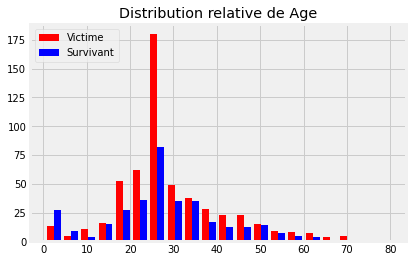

In [12]:
plot_hist('Age')

On remarque qu'il y a beaucoup plus de morts dans les personnes agées de plus de 10 ans, et que les enfants de moins de 10 ans ont plutôt tendance à survivre. Il peut alors être pertinent de sélectionner l'âge dans le modèle. On créé alors une nouvelle variable à partir du dataset, que l'on nomme `Child`. Elle vaut `True` si l'âge est inférieur à 10, et `False` sinon. Là encore, on transforme cette variable qualitative en quantitative en créant 2 colonnes, une pour chaque valeur de `Child`.

In [13]:
data['Child'] = data['Age'] < 10

to_dummify = "Child"
X_dummy, dummy_columns, dummy_encoder = preprocess.dummify_features(pd.DataFrame(data[to_dummify]))
data = data.join(X_dummy)

In [14]:
features = ['SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Child_True', 'Child_False']

model, X_test, y_test = models.logistic(data, features)
print(classification_report(model.predict(X_test), y_test))
scores = models.cross_val_model(data, LogisticRegression(), features)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


              precision    recall  f1-score   support

           0       0.83      0.72      0.77       128
           1       0.47      0.63      0.54        51

    accuracy                           0.69       179
   macro avg       0.65      0.67      0.65       179
weighted avg       0.73      0.69      0.70       179

Accuracy: 0.71 (+/- 0.10)


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Quatrième modélisation : Random Forest avec les mêmes features

Une autre approche est l'utilisation de modèles ensemblistes, comme les Random Foerst. Ce modèle se base sur plusieurs arbres de décisions, pris de manières aléatoires pour diminuer le biais sans faire augmenter la variance. En utilisant un Random Forest avec les mêmes features, j'obtiens les résultats suivants :

In [15]:
from sklearn.ensemble import RandomForestClassifier

features = ['SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Child']
model, X_test, y_test = models.random_forest(data, features)
print(classification_report(model.predict(X_test), y_test))
scores = models.cross_val_model(data, RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=2), features)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Maximum reached : %0.2f" % max(scores))

              precision    recall  f1-score   support

           0       0.89      0.70      0.79       142
           1       0.37      0.68      0.48        37

    accuracy                           0.70       179
   macro avg       0.63      0.69      0.63       179
weighted avg       0.79      0.70      0.72       179

Accuracy: 0.73 (+/- 0.10)
Maximum reached : 0.78


On obtient avec cette méthode ensembliste de meilleurs scores ainsi qu'une variance un peu plus faible qu'avec la régression logistique.

## Random Forest en ajoutant le sexe des passagers

Essayons maintenant de prendre en compte le sexe des personnes :

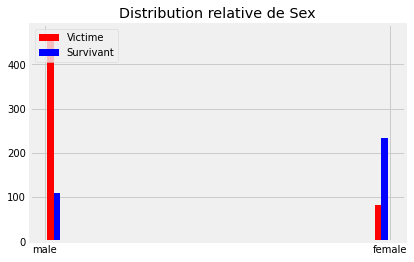

In [16]:
plot_hist('Sex')

Il est clair que la majorité des victimes proviennent ici des hommes, alors que les femmes ont plus tendance à survivre. Ajoutons donc le sexe à notre modèle. Ici encore, c'est une variable qualitative, on va donc créer deux colonnes `Sex_male` et `Sex_female` pour la transformer en variable quantitative. On obtient alors les résultats suivants :

In [17]:
to_dummify = "Sex"
X_dummy, dummy_columns, dummy_encoder = preprocess.dummify_features(pd.DataFrame(data[to_dummify]))
data = data.join(X_dummy)

In [18]:
features = ['SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Child', 'Sex_male', 'Sex_female']

model, X_test, y_test = models.random_forest(data, features)
print(classification_report(model.predict(X_test), y_test))
scores = models.cross_val_model(data, RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=2), features)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Maximum reached : %0.2f" % max(scores))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85       118
           1       0.69      0.79      0.73        61

    accuracy                           0.80       179
   macro avg       0.78      0.80      0.79       179
weighted avg       0.81      0.80      0.81       179

Accuracy: 0.83 (+/- 0.06)
Maximum reached : 0.88


On remarque une très nette amélioration du modèle, en montant à un score de 0.83 en moyenne avec une variance très faible (intervalle de confiance à 95% assez petit).

Les variables à prendre en compte dans la prédiction de la survavibilité des passagers du titanic semble donc être :
`SibSp`, `Parch`, `Fare`, `Pclass`, `Child` et `Sex`, avec `Child` qui vaut `True` si `Age` est inférieur à 10. Les meilleurs performances ont ici été atteintes avec une méthode ensembliste, Random Forest.